In [ ]:
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia',
                'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
                'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania',
                'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']

selected_countries = ['Portugal', 'Spain']

In [ ]:
import pandas as pd

path = '/content/data_cts_intentional_homicide.xlsx'
df_homicides = pd.read_excel(path,skiprows=2)
df_homicides = df_homicides[(df_homicides['Dimension'] == 'Total') & (df_homicides['Indicator'] == 'Victims of intentional homicide') & (df_homicides['Sex']=='Total') &
                            (df_homicides['Unit of measurement']=='Rate per 100,000 population')]
df_homicides = df_homicides.groupby(['Country','Year'])['VALUE'].sum().reset_index()
df_homicides.rename(columns={'Country':'location','VALUE':'val','Year': 'year'}, inplace=True)
df_homicides = df_homicides.sort_values(['year','location'])

In [ ]:
path = '/content/OECD.SDD.TPS,DSD_LFS@DF_IALFS_UNE_Q,1.0+all.csv'
df_unemployment = pd.read_csv(path)
df_unemployment = df_unemployment[df_unemployment['Sex'] == 'Total']
df_unemployment = df_unemployment.groupby(['Reference area','TIME_PERIOD'])['OBS_VALUE'].sum().reset_index()
df_unemployment = df_unemployment[df_unemployment['TIME_PERIOD'].astype(str).str.len() < 5]
df_unemployment.rename(columns={'Reference area':'location','OBS_VALUE':'num_unemployment','TIME_PERIOD': 'year'}, inplace=True)
df_unemployment['year'] = df_unemployment['year'].astype(int)
df_unemployment = df_unemployment[df_unemployment['year'] > 1979]

In [ ]:
path = '/content/population.csv'
df_population = pd.read_csv(path)
df_population.rename(columns={'Entity':'location','Population (historical)':'population','Year': 'year'}, inplace=True)
df_population = df_population[['location','year','population']]
df_population = df_population[df_population['year'].astype(int) > 1979]
df_population['year'] = df_population['year'].astype(int)

In [ ]:
path = '/content/IHME-GBD_2021_DATA-9e7c7802-1.csv'
df_IHME = pd.read_csv(path)
df_IHME = df_IHME[df_IHME['year'] >= 1980]
df_IHME = df_IHME.sort_values('year')

##Unemployed

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib.colors import Normalize
import ipywidgets as widgets
from IPython.display import display
import matplotlib.animation as animation
from IPython.display import HTML
import statsmodels.formula.api as sm


def compute_pre_post_matrix(df, country1, country2, val_col, years_list):
    """
    Computes the pre-post matrix for a difference-in-differences analysis.

    Args:
        df: The dataframe.
        country1: The treated country.
        country2: The control country.
        val_col: The column with the values to analyze.
        years_list: A list of years to include.
    """

    country1_data = df[(df['location'] == country1)][['location','year',val_col]]
    country1_data = country1_data[country1_data['year'].isin(years_list)]
    country1_data = country1_data.pivot(index='location', columns='year', values=val_col)
    country1_data.reset_index(inplace=True)

    country2_data = df[(df['location'] == country2)][['location','year',val_col]]
    country2_data = country2_data[country2_data['year'].isin(years_list)]
    country2_data = country2_data.pivot(index='location', columns='year', values=val_col)
    country2_data.reset_index(inplace=True)

    pre_post_matrix = pd.concat([country2_data,country1_data], axis=0).reset_index(drop=True)

    diff_row = pre_post_matrix[years_list].diff(axis=0).iloc[1]
    diff_row_df = pd.DataFrame([diff_row], columns=years_list)
    diff_row_df['location'] = 'Diff'
    pre_post_matrix = pd.concat([pre_post_matrix, diff_row_df], ignore_index=True)

    sum_of_columns = pre_post_matrix[years_list[2:]].sum(axis=1) - pre_post_matrix[years_list[:2]].sum(axis=1)
    pre_post_matrix['DiD'] = sum_of_columns

    return pre_post_matrix

In [ ]:
path = '/content/OECD.SDD.TPS,DSD_LFS@DF_IALFS_UNE_Q,1.0+all.csv'
df_unemployment = pd.read_csv(path)
df_unemployment = df_unemployment[df_unemployment['Sex'] == 'Total']
df_unemployment = df_unemployment.groupby(['Reference area','TIME_PERIOD'])['OBS_VALUE'].sum().reset_index()
df_unemployment = df_unemployment[df_unemployment['TIME_PERIOD'].astype(str).str.len() < 5]
df_unemployment.rename(columns={'Reference area':'location','OBS_VALUE':'num_unemployment','TIME_PERIOD': 'year'}, inplace=True)
df_unemployment['year'] = df_unemployment['year'].astype(int)
df_unemployment = df_unemployment[df_unemployment['year'] > 1979]

In [ ]:
path = '/content/population.csv'
df_population = pd.read_csv(path)
df_population.rename(columns={'Entity':'location','Population (historical)':'population','Year': 'year'}, inplace=True)
df_population = df_population[['location','year','population']]
df_population = df_population[df_population['year'].astype(int) > 1979]
df_population['year'] = df_population['year'].astype(int)

In [ ]:
df_unemployment = pd.merge(df_population, df_unemployment, how='inner', on=['location','year'])
df_unemployment['val'] = df_unemployment['num_unemployment'] / df_unemployment['population']
df_unemployment

,location,year,population,num_unemployment,val
0,Australia,1980,14721343,2445.74638,0.000166
1,Australia,1981,14949209,2356.37964,0.000158
2,Australia,1982,15192485,2966.31032,0.000195
3,Australia,1983,15414891,4178.38748,0.000271
4,Australia,1984,15620650,3841.91226,0.000246
...,...,...,...,...,...
1447,United States,2019,337790068,46615.99860,0.000138
1448,United States,2020,339436157,100121.49400,0.000295
1449,United States,2021,340161441,66952.66600,0.000197
1450,United States,2022,341534041,46549.16660,0.000136


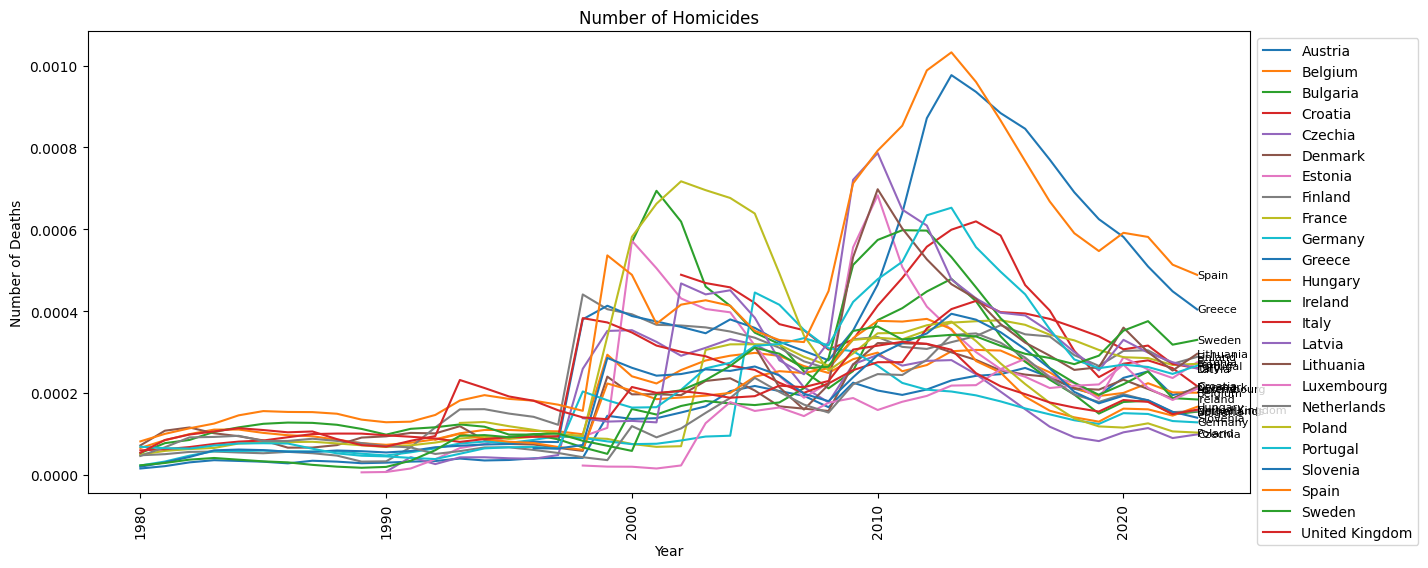

In [ ]:
import matplotlib.pyplot as plt

df_selected_countries = df_unemployment[df_unemployment['location'].isin(eu_countries)]

plt.figure(figsize=(15, 6))

for country in df_selected_countries['location'].unique():
    df_country = df_selected_countries[df_selected_countries['location'] == country]
    plt.plot(df_country['year'], df_country['val'], label=country)

    last_year = df_country['year'].iloc[-1]
    last_val = df_country['val'].iloc[-1]
    plt.text(last_year, last_val, country, fontsize=8, ha='left', va='center')

plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=90)
plt.title('Number of Homicides')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

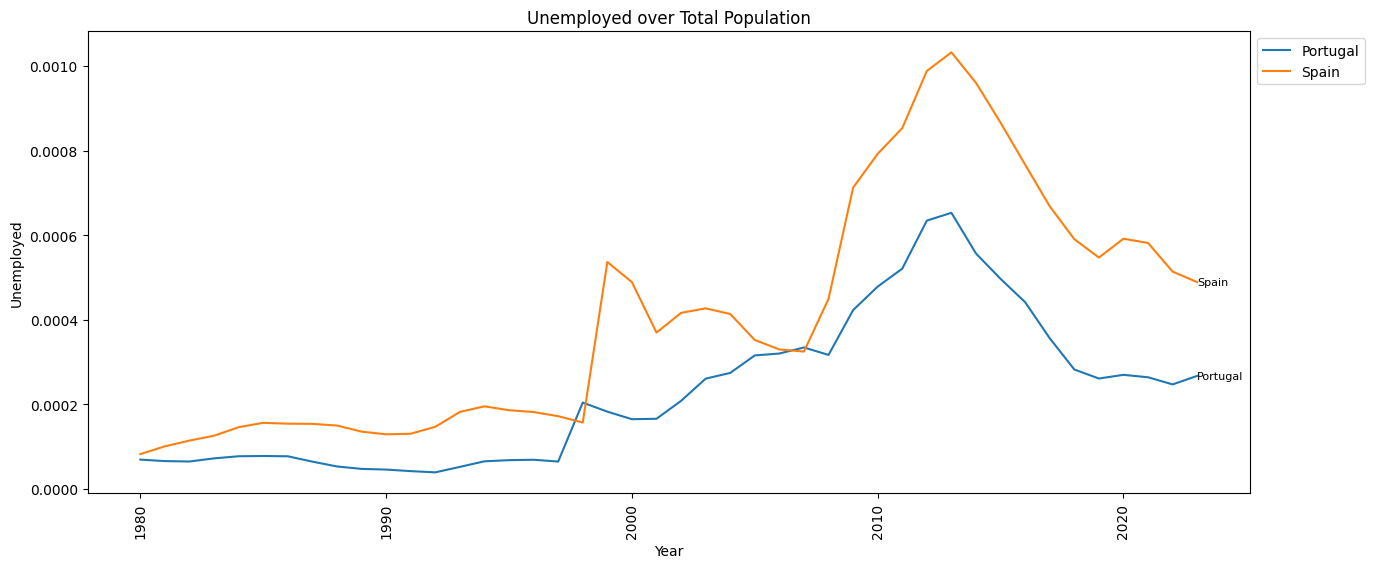

In [ ]:
import matplotlib.pyplot as plt

df_selected_countries = df_unemployment[df_unemployment['location'].isin(selected_countries)]

plt.figure(figsize=(15, 6))

for country in df_selected_countries['location'].unique():
    df_country = df_selected_countries[df_selected_countries['location'] == country]
    plt.plot(df_country['year'], df_country['val'], label=country)

    last_year = df_country['year'].iloc[-1]
    last_val = df_country['val'].iloc[-1]
    plt.text(last_year, last_val, country, fontsize=8, ha='left', va='center')

plt.xlabel('Year')
plt.ylabel('Unemployed')
plt.xticks(rotation=90)
plt.title('Unemployed over Total Population')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

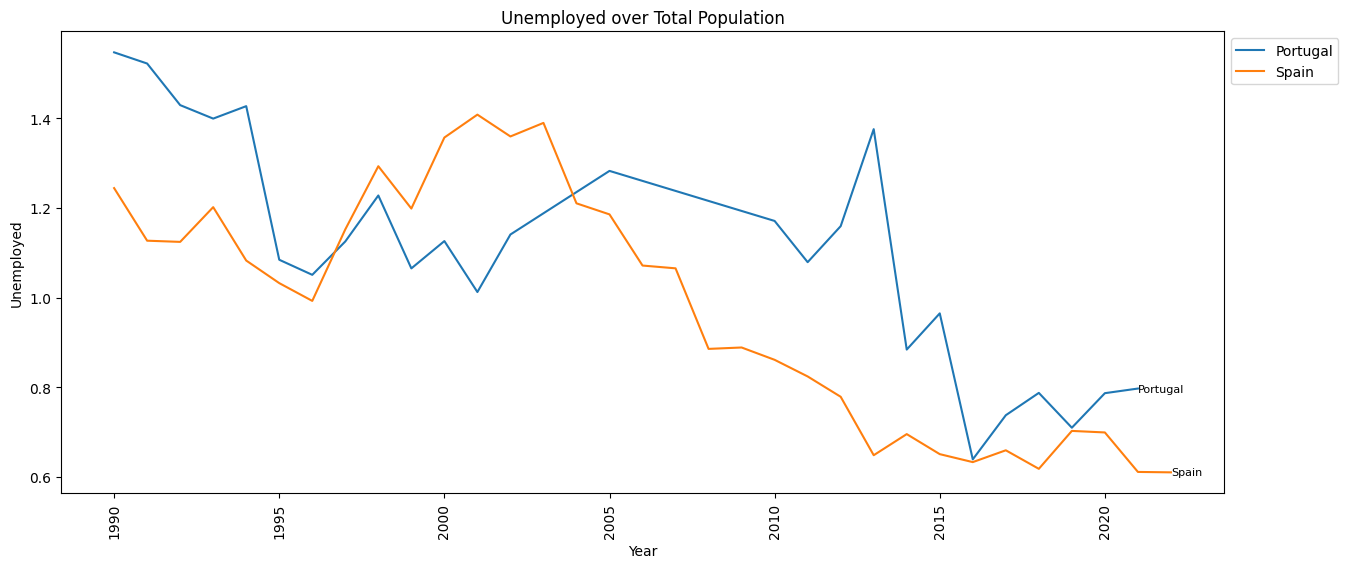

In [ ]:
import matplotlib.pyplot as plt

df_selected_countries = df_homicides[df_homicides['location'].isin(selected_countries)]

plt.figure(figsize=(15, 6))

for country in df_selected_countries['location'].unique():
    df_country = df_selected_countries[df_selected_countries['location'] == country]
    plt.plot(df_country['year'], df_country['val'], label=country)

    last_year = df_country['year'].iloc[-1]
    last_val = df_country['val'].iloc[-1]
    plt.text(last_year, last_val, country, fontsize=8, ha='left', va='center')

plt.xlabel('Year')
plt.ylabel('Unemployed')
plt.xticks(rotation=90)
plt.title('Unemployed over Total Population')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
df_homicides[df_homicides['location'] == 'Italy']

,location,year,val
1906,Italy,1990,3.160868
1907,Italy,1991,3.412303
1908,Italy,1992,2.597074
1909,Italy,1993,1.883261
1910,Italy,1994,1.703472
1911,Italy,1995,1.779024
1912,Italy,1996,1.674898
1913,Italy,1997,1.533575
1914,Italy,1998,1.561327
1915,Italy,1999,1.438228


<ipython-input-14-828bf5ff31b9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['population'] = pd.to_numeric(df_country['population'])


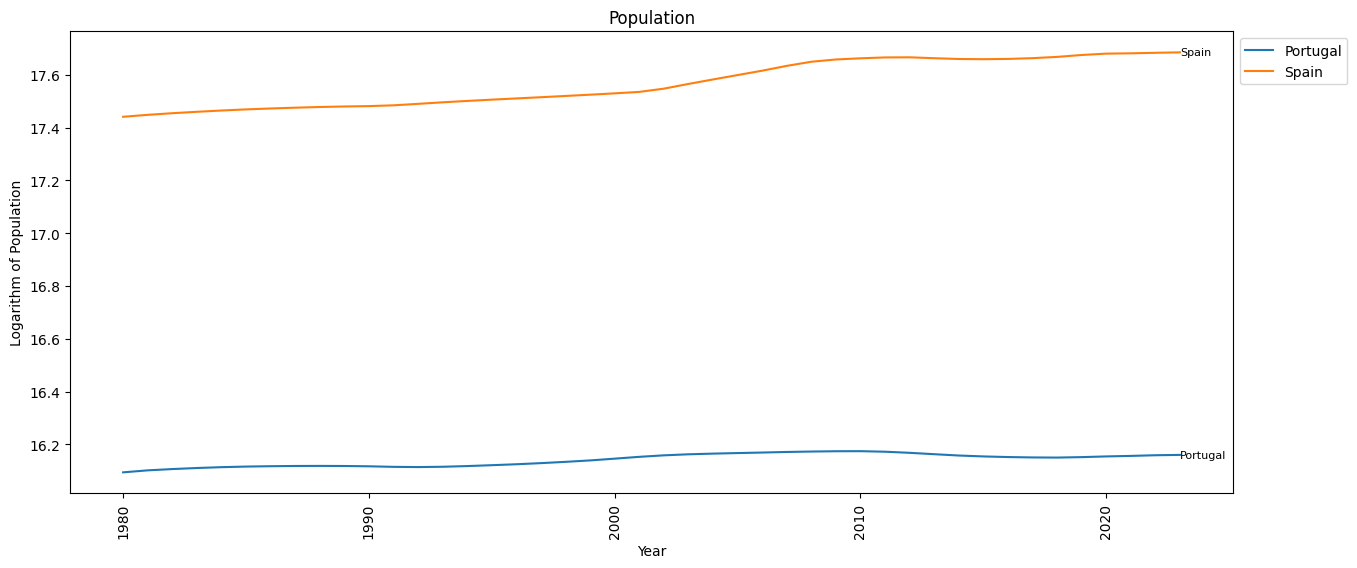

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df_population_selected = df_population[df_population['location'].isin(selected_countries)]

plt.figure(figsize=(15, 6))

for country in df_population_selected['location'].unique():
    df_country = df_population_selected[df_population_selected['location'] == country]

    df_country['population'] = pd.to_numeric(df_country['population'])
    df_country = df_country[df_country['population'] > 0]  # Filter out non-positive values

    plt.plot(df_country['year'], np.log(df_country['population']), label=country)

    last_year = df_country['year'].iloc[-1]
    last_val = df_country['population'].iloc[-1]
    plt.text(last_year, np.log(last_val), country, fontsize=8, ha='left', va='center') # Apply log to last_val here as well

plt.xlabel('Year')
plt.ylabel('Logarithm of Population') # Update y-label
plt.xticks(rotation=90)
plt.title('Population')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
def compute_pre_post_matrix(df, country1, country2, value, years):
  """Computes the pre-post matrix for two countries and a specific cause.

  Args:
    df_IHME: The DataFrame containing IHME data.
    country1: The first country.
    country2: The second country.
    cause: The cause of death.
    years: A list of years for the pre-post analysis.

  Returns:
    A DataFrame representing the pre-post matrix.
  """

  country1_data = df[(df['location'] == country1)]
  country2_data = df[(df['location'] == country2)]

  country1_data = country1_data[country1_data['year'].isin(years)][['location','year',value]]
  country1_data = country1_data.pivot(index='location', columns='year', values=value)
  country1_data.reset_index(inplace=True)

  country2_data = country2_data[country2_data['year'].isin(years)][['location','year',value]]
  country2_data = country2_data.pivot(index='location', columns='year', values=value)
  country2_data.reset_index(inplace=True)

  pre_post_matrix = pd.concat([country1_data,country2_data], axis=0).reset_index(drop=True)

  sum_of_columns = pre_post_matrix[years[2:]].sum(axis=1) - pre_post_matrix[years[:2]].sum(axis=1)
  pre_post_matrix['DiD'] = sum_of_columns
  pre_post_matrix['DiD_%Change'] = round(sum_of_columns/pre_post_matrix[years[0]],4) * 100

  diff_row = pre_post_matrix.iloc[:,1:].diff(axis=0).iloc[1] * (-1)
  diff_row_df = pd.DataFrame([diff_row], columns=pre_post_matrix.columns[1:])
  diff_row_df['location'] = 'Diff'
  pre_post_matrix = pd.concat([pre_post_matrix, diff_row_df], ignore_index=True)

  return pre_post_matrix

pre_post_matrix = compute_pre_post_matrix(df_unemployment, 'Portugal', 'Spain', 'val', [1997, 1999, 2002, 2005]) # No more than four years
pre_post_matrix

year,location,1997,1999,2002,2005,DiD,DiD_%Change
0,Portugal,0.000064,0.000182,0.000208,0.000315,0.000277,432.14
1,Spain,0.000171,0.000536,0.000416,0.000352,0.000060,34.97
2,Diff,-0.000107,-0.000354,-0.000208,-0.000036,0.000217,397.17


In [ ]:
pre_post_matrix = compute_pre_post_matrix(df_population, 'Portugal', 'Spain', 'population', [1997, 1999, 2002, 2005]) # No more than four years
pre_post_matrix

year,location,1997,1999,2002,2005,DiD,DiD_%Change
0,Portugal,10110548.0,10214877.0,10413046.0,10502994.0,590615.0,5.84
1,Spain,40423823.0,40812855.0,41755702.0,43958884.0,4477908.0,11.08
2,Diff,-30313275.0,-30597978.0,-31342656.0,-33455890.0,-3887293.0,-5.24


In [ ]:
pre_post_matrix = compute_pre_post_matrix(df_homicides, 'Portugal', 'Spain', 'val', [1997, 1999, 2002, 2005]) # No more than four years
pre_post_matrix

year,location,1997,1999,2002,2005,DiD,DiD_%Change
0,Portugal,1.125309,1.065143,1.140840,1.282866,0.233253,20.73
1,Spain,1.152313,1.198750,1.359768,1.185752,0.194457,16.88
2,Diff,-0.027004,-0.133607,-0.218929,0.097114,0.038797,3.85


In [ ]:
import pandas as pd

selected_serie = 'International tourism, number of arrivals' # ['International tourism, number of arrivals','International tourism, number of departures','International tourism, receipts (current US$)',
                                                             #  'International tourism, receipts (% of total exports)', 'International tourism, expenditures (current US$)', 'International tourism, expenditures (% of total imports)']
df_tourism = pd.read_excel('/content/P_Data_Extract_From_World_Development_Indicators.xlsx')
df_tourism.rename(columns={f'{year} [YR{year}]': year for year in range(1960,2024)}, inplace=True)
df_tourism = pd.concat([df_tourism.iloc[:, 0], df_tourism.iloc[:, 2], df_tourism.iloc[:, 4:]], axis=1)
df_tourism.dropna(inplace=True)
df_tourism.rename(columns={'Country Name':'location'}, inplace=True)
df_tourism = df_tourism[df_tourism['Series Name'] == selected_serie]
df_tourism = df_tourism.replace('..', None)
df_tourism.dropna(axis=1, how='all', inplace=True)
df_tourism = df_tourism.iloc[:,1:]
df_tourism = df_tourism.melt(id_vars=['location'], var_name='year', value_name='val')
df_tourism['year'] = df_tourism['year'].astype(int)

<ipython-input-19-eef1d9b944d0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['val'] = pd.to_numeric(df_country['val'])


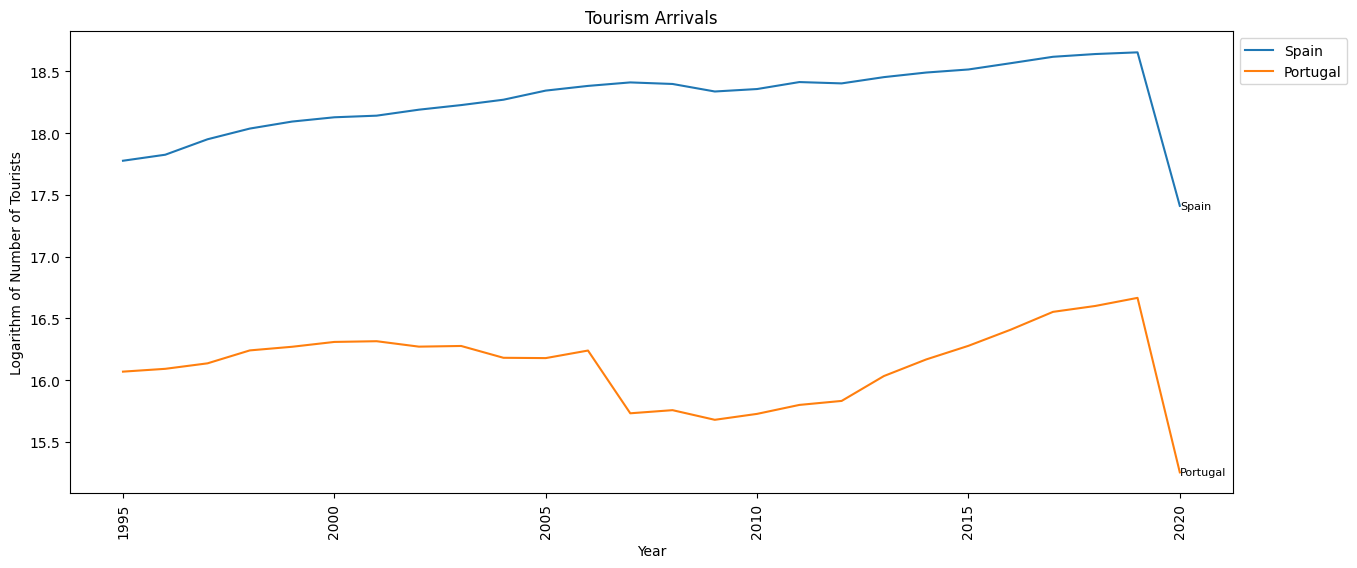

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df_tourism_selected = df_tourism[df_tourism['location'].isin(selected_countries)]

plt.figure(figsize=(15, 6))

for country in df_tourism_selected['location'].unique():
    df_country = df_tourism_selected[df_tourism_selected['location'] == country]

    # Convert 'val' column to numeric type and handle invalid values
    df_country['val'] = pd.to_numeric(df_country['val'])
    df_country = df_country[df_country['val'] > 0]  # Filter out non-positive values

    plt.plot(df_country['year'], np.log(df_country['val']), label=country)

    last_year = df_country['year'].iloc[-1]
    last_val = df_country['val'].iloc[-1]
    plt.text(last_year, np.log(last_val), country, fontsize=8, ha='left', va='center') # Apply log to last_val here as well

plt.xlabel('Year')
plt.ylabel('Logarithm of Number of Tourists') # Update y-label
plt.xticks(rotation=90)
plt.title('Tourism Arrivals')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
pre_post_matrix = compute_pre_post_matrix(df_tourism, 'Portugal', 'Spain', 'val', [1997, 1999, 2002, 2005]) # Four years needed
pre_post_matrix

year,location,1997,1999,2002,2005,DiD,DiD_%Change
0,Portugal,10172000,11632000,11644000,10612000,452000,4.443571
1,Spain,62415000,72040000,79313000,92563000,37421000,59.955139
2,Diff,-52243000,-60408000,-67669000,-81951000,-36969000,-55.511568


# Drugs

## Homicides

In [ ]:
import pandas as pd
path = '/content/data_cts_intentional_homicide.xlsx'
df_homicides = pd.read_excel(path,skiprows=2)
df_homicides = df_homicides[(df_homicides['Dimension'] == 'Total') & (df_homicides['Indicator'] == 'Victims of intentional homicide') & (df_homicides['Sex']=='Total') &
                            (df_homicides['Unit of measurement']=='Rate per 100,000 population')]
df_homicides = df_homicides.groupby(['Country','Year'])['VALUE'].sum().reset_index()
df_homicides.rename(columns={'Country':'location','VALUE':'val','Year': 'year'}, inplace=True)
df_homicides = df_homicides.sort_values(['year','location'])

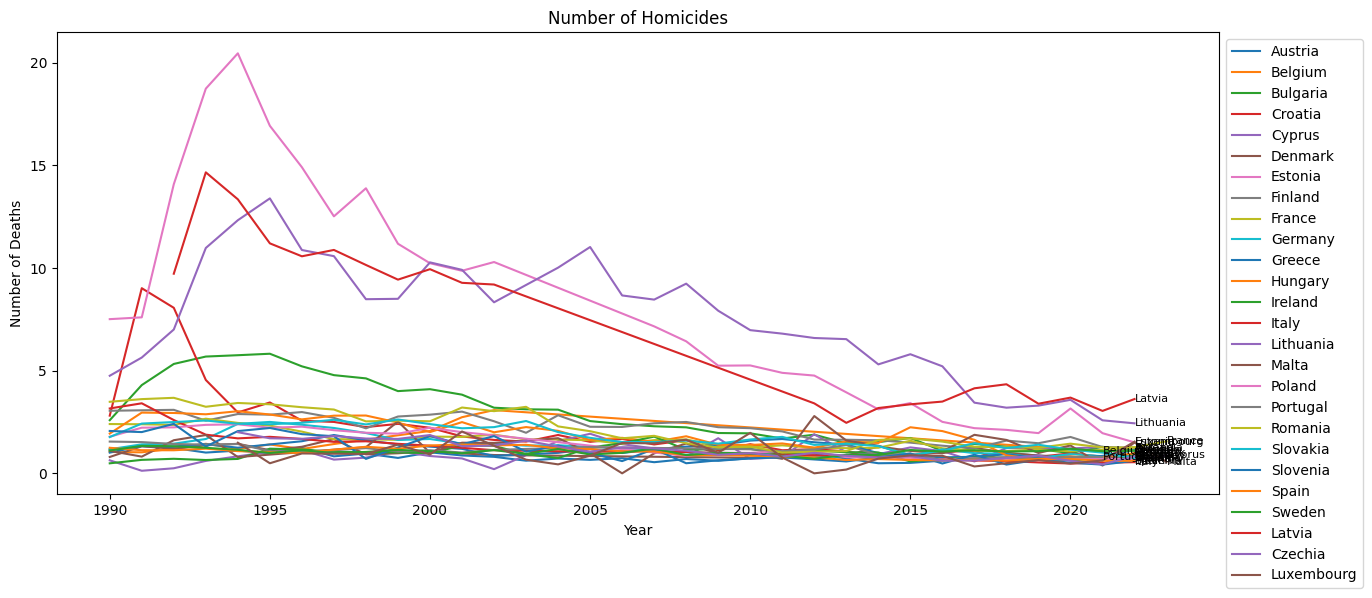

In [ ]:
import matplotlib.pyplot as plt

df_selected_countries = df_homicides[df_homicides['location'].isin(eu_countries)]

plt.figure(figsize=(15, 6))

for country in df_selected_countries['location'].unique():
    df_country = df_selected_countries[df_selected_countries['location'] == country]
    plt.plot(df_country['year'], df_country['val'], label=country)

    last_year = df_country['year'].iloc[-1]
    last_val = df_country['val'].iloc[-1]
    plt.text(last_year, last_val, country, fontsize=8, ha='left', va='center')

plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.title('Number of Homicides')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

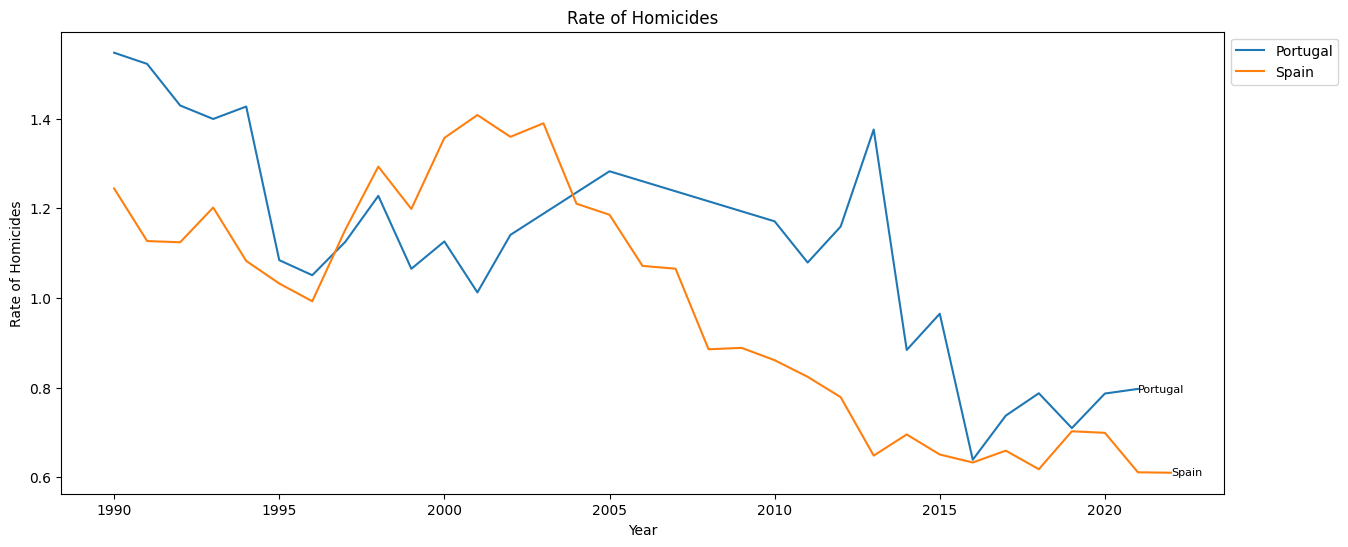

In [ ]:
import matplotlib.pyplot as plt

df_selected_countries = df_homicides[df_homicides['location'].isin(selected_countries)]

plt.figure(figsize=(15, 6))

for country in df_selected_countries['location'].unique():
    df_country = df_selected_countries[df_selected_countries['location'] == country]
    plt.plot(df_country['year'], df_country['val'], label=country)

    last_year = df_country['year'].iloc[-1]
    last_val = df_country['val'].iloc[-1]
    plt.text(last_year, last_val, country, fontsize=8, ha='left', va='center')

plt.xlabel('Year')
plt.ylabel('Rate of Homicides')
plt.title('Rate of Homicides')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## IHME

In [ ]:
import pandas as pd

path = '/content/IHME-GBD_2021_DATA-9e7c7802-1.csv'
df_IHME = pd.read_csv(path)
df_IHME = df_IHME[df_IHME['year'] >= 1980]
df_IHME = df_IHME.sort_values('year')
df_IHME

,measure,location,sex,age,cause,metric,year,val,upper,lower
0,Deaths,Ireland,Both,All ages,Other drug use disorders,Number,1980,7.833847,8.797275,7.000436
166,Deaths,Bulgaria,Both,All ages,Opioid use disorders,Number,1980,16.312118,19.900876,13.200327
167,Deaths,Bulgaria,Both,All ages,Cocaine use disorders,Number,1980,1.411054,1.962659,1.113481
168,Deaths,Estonia,Both,All ages,Opioid use disorders,Number,1980,41.534495,48.333299,35.828993
169,Deaths,Estonia,Both,All ages,Cocaine use disorders,Number,1980,4.536574,6.125437,3.105310
...,...,...,...,...,...,...,...,...,...,...
7831,Deaths,Slovenia,Both,All ages,Amphetamine use disorders,Number,2021,1.348468,1.672406,1.059872
7832,Deaths,Slovenia,Both,All ages,Other drug use disorders,Number,2021,3.156611,4.031699,2.504629
7854,Deaths,Romania,Both,All ages,Drug use disorders,Number,2021,193.845695,226.955306,159.391140
7415,Deaths,Estonia,Both,All ages,Cocaine use disorders,Number,2021,1.547609,1.998650,1.216131


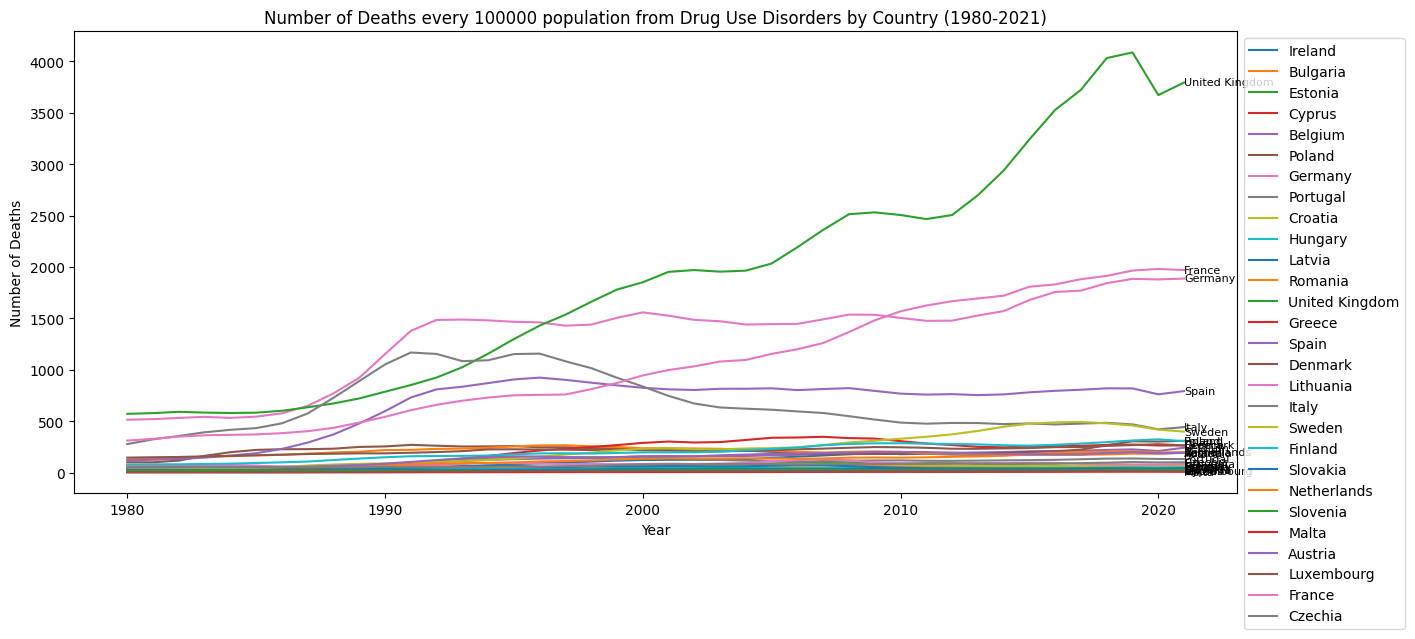

In [ ]:
import matplotlib.pyplot as plt

df_selected_countries = df_IHME[df_IHME['location'].isin(eu_countries)]

plt.figure(figsize=(15, 6))

for country in df_selected_countries['location'].unique():
    df_country = df_IHME[(df_IHME['location'] == country) & (df_IHME['cause'] == 'Drug use disorders')]
    plt.plot(df_country['year'], df_country['val'], label=country)

    last_year = df_country['year'].iloc[-1]
    last_val = df_country['val'].iloc[-1]
    plt.text(last_year, last_val, country, fontsize=8, ha='left', va='center')

plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.title('Number of Deaths every 100000 population from Drug Use Disorders by Country (1980-2021)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
df_IHME

,measure,location,sex,age,cause,metric,year,val,upper,lower
0,Deaths,Ireland,Both,All ages,Other drug use disorders,Number,1980,7.833847,8.797275,7.000436
166,Deaths,Bulgaria,Both,All ages,Opioid use disorders,Number,1980,16.312118,19.900876,13.200327
167,Deaths,Bulgaria,Both,All ages,Cocaine use disorders,Number,1980,1.411054,1.962659,1.113481
168,Deaths,Estonia,Both,All ages,Opioid use disorders,Number,1980,41.534495,48.333299,35.828993
169,Deaths,Estonia,Both,All ages,Cocaine use disorders,Number,1980,4.536574,6.125437,3.105310
...,...,...,...,...,...,...,...,...,...,...
7831,Deaths,Slovenia,Both,All ages,Amphetamine use disorders,Number,2021,1.348468,1.672406,1.059872
7832,Deaths,Slovenia,Both,All ages,Other drug use disorders,Number,2021,3.156611,4.031699,2.504629
7854,Deaths,Romania,Both,All ages,Drug use disorders,Number,2021,193.845695,226.955306,159.391140
7415,Deaths,Estonia,Both,All ages,Cocaine use disorders,Number,2021,1.547609,1.998650,1.216131


<ipython-input-27-0fadd3068c2d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['val'] = pd.to_numeric(df_country['val'])


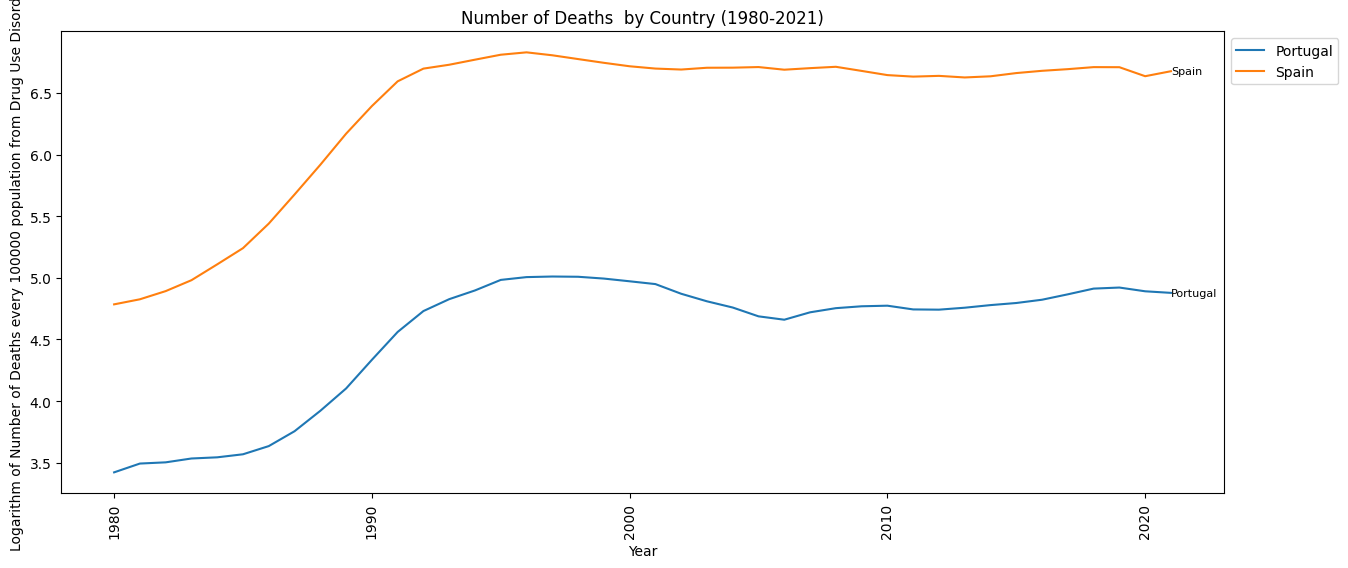

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df_selected_countries = df_IHME[df_IHME['location'].isin(selected_countries)]

plt.figure(figsize=(15, 6))

for country in df_selected_countries['location'].unique():
    df_country = df_IHME[(df_IHME['location'] == country) & (df_IHME['cause'] == 'Drug use disorders')]

    # Convert 'val' column to numeric type and handle invalid values
    df_country['val'] = pd.to_numeric(df_country['val'])
    df_country = df_country[df_country['val'] > 0]  # Filter out non-positive values

    plt.plot(df_country['year'], np.log(df_country['val']), label=country)

    last_year = df_country['year'].iloc[-1]
    last_val = df_country['val'].iloc[-1]
    plt.text(last_year, np.log(last_val), country, fontsize=8, ha='left', va='center') # Apply log to last_val here as well

plt.xlabel('Year')
plt.ylabel('Logarithm of Number of Deaths every 100000 population from Drug Use Disorders') # Update y-label
plt.xticks(rotation=90)
plt.title('Number of Deaths  by Country (1980-2021)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

<ipython-input-28-2ad316058d9d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['val'] = pd.to_numeric(df_country['val'])


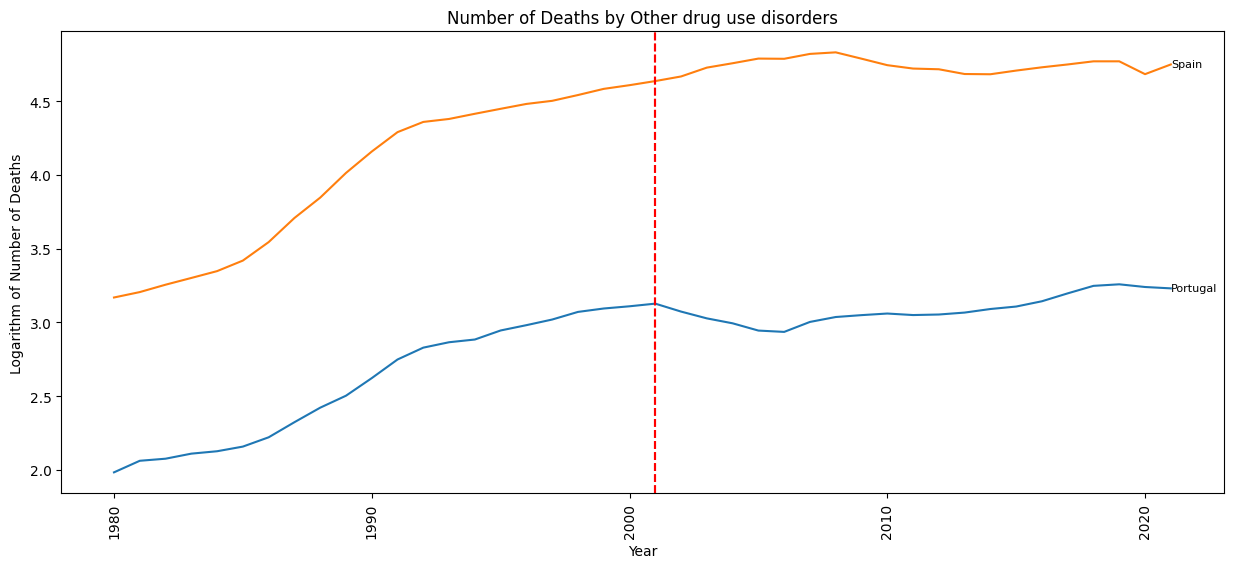

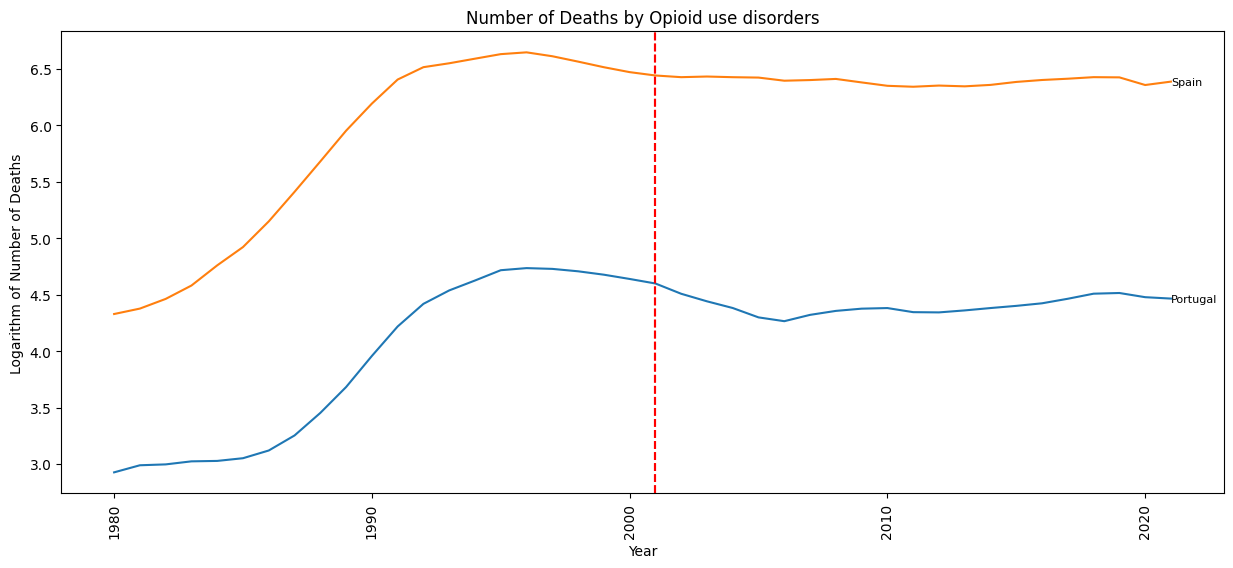

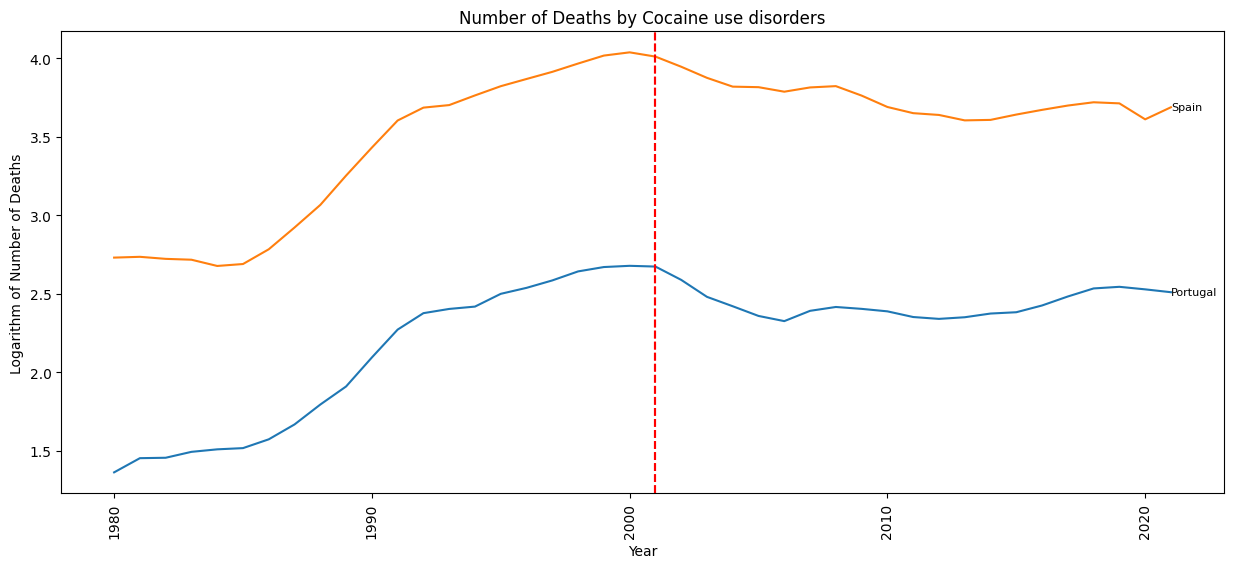

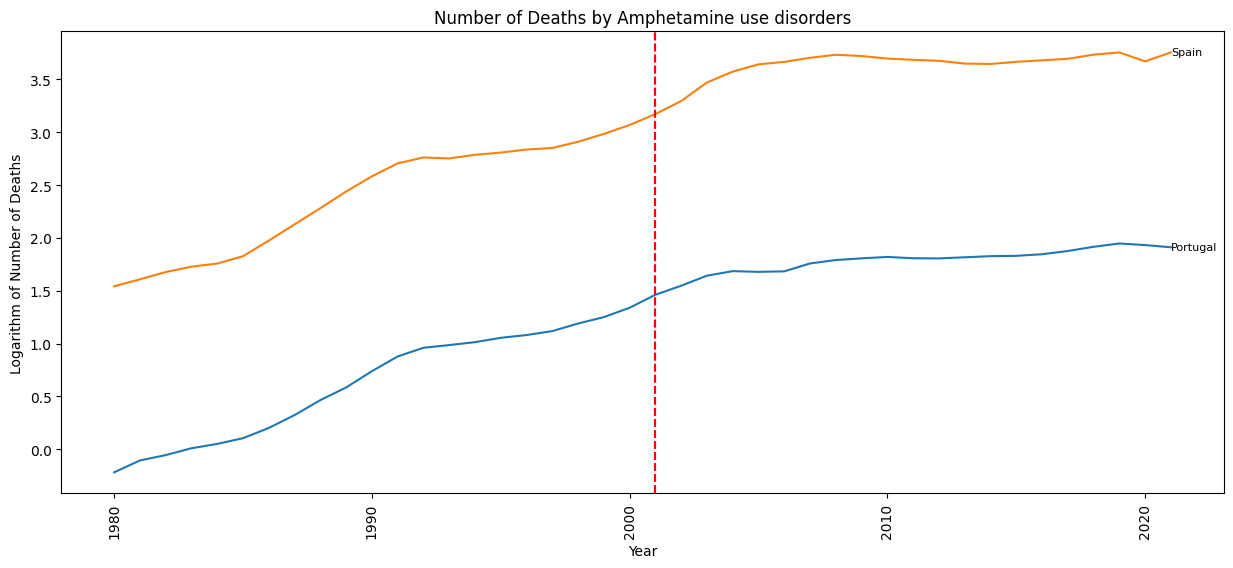

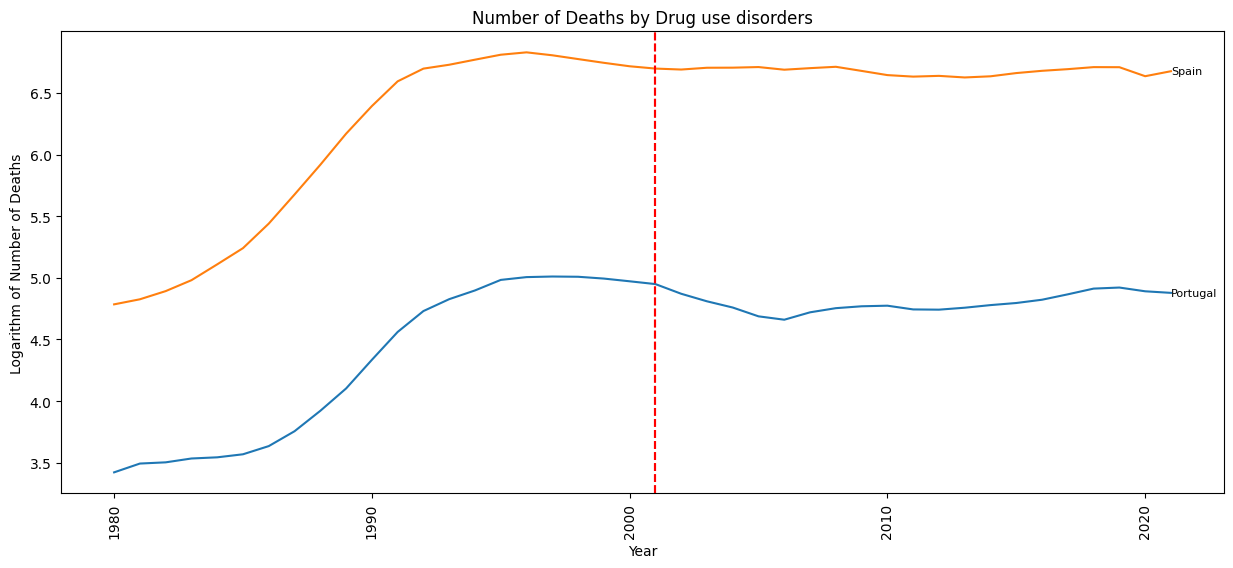

In [ ]:
import matplotlib.pyplot as plt

df_selected = df_IHME[df_IHME['location'].isin(selected_countries)]

for cause in df_IHME['cause'].unique():

    plt.figure(figsize=(15, 6))

    for country in df_selected_countries['location'].unique():
        df_country = df_IHME[(df_IHME['location'] == country) & (df_IHME['cause'] == cause)]

        # Convert 'val' column to numeric type and handle invalid values
        df_country['val'] = pd.to_numeric(df_country['val'])
        df_country = df_country[df_country['val'] > 0]  # Filter out non-positive values

        plt.plot(df_country['year'], np.log(df_country['val']), label=country)

        plt.axvline(x=2001, color='red', linestyle='--', label='Year 2001')

        last_year = df_country['year'].iloc[-1]
        last_val = df_country['val'].iloc[-1]
        plt.text(last_year, np.log(last_val), country, fontsize=8, ha='left', va='center') # Apply log to last_val here as well

    plt.xlabel('Year')
    plt.ylabel('Logarithm of Number of Deaths')
    plt.xticks(rotation=90)
    plt.title(f'Number of Deaths by {cause}')
    plt.show()

In [ ]:
portugal = df_IHME[(df_IHME['location'] == 'Portugal') & (df_IHME['cause'] == 'Drug use disorders')]
spain = df_IHME[(df_IHME['location'] == 'Spain') & (df_IHME['cause'] == 'Drug use disorders')]

portugal_data = portugal[portugal['year'].isin([1997, 1998, 1999, 2000])][['location','year','val']]
portugal_data = portugal_data.pivot(index='location', columns='year', values='val')
portugal_data.reset_index(inplace=True)

spain_data = spain[spain['year'].isin([1997, 1998, 1999, 2000])][['location','year','val']]
spain_data = spain_data.pivot(index='location', columns='year', values='val')
spain_data.reset_index(inplace=True)

pre_post_matrix = pd.concat([spain_data,portugal_data], axis=0).reset_index(drop=True)

diff_row = pre_post_matrix[[1997, 1998, 1999, 2000]].diff(axis=0).iloc[1]
diff_row_df = pd.DataFrame([diff_row], columns=[1997, 1998, 1999, 2000])
diff_row_df['location'] = 'Diff'
pre_post_matrix = pd.concat([pre_post_matrix, diff_row_df], ignore_index=True)

sum_of_columns = pre_post_matrix[[1999,2000]].sum(axis=1) - pre_post_matrix[[1997,1998]].sum(axis=1)
pre_post_matrix['DiD'] = sum_of_columns
pre_post_matrix

,location,1997,1998,1999,2000,DiD
0,Spain,902.326060,875.056469,848.829833,825.385568,-103.167129
1,Portugal,149.942628,149.645092,147.465413,144.248819,-7.873488
2,Diff,-752.383432,-725.411377,-701.364420,-681.136749,95.293641


In [ ]:
portugal = df_IHME[(df_IHME['location'] == 'Portugal') & (df_IHME['cause'] == 'Drug use disorders')]
spain = df_IHME[(df_IHME['location'] == 'Spain') & (df_IHME['cause'] == 'Drug use disorders')]

portugal_data = portugal[portugal['year'].isin([1991, 2000, 2002, 2011])][['location','year','val']]
portugal_data = portugal_data.pivot(index='location', columns='year', values='val')
portugal_data.reset_index(inplace=True)

spain_data = spain[spain['year'].isin([1991, 2000, 2002, 2011])][['location','year','val']]
spain_data = spain_data.pivot(index='location', columns='year', values='val')
spain_data.reset_index(inplace=True)

pre_post_matrix = pd.concat([spain_data,portugal_data], axis=0).reset_index(drop=True)

diff_row = pre_post_matrix[[1991, 2000, 2002, 2011]].diff(axis=0).iloc[1] * (-1)
diff_row_df = pd.DataFrame([diff_row], columns=[1991, 2000, 2002, 2011])
diff_row_df['location'] = 'Diff'
pre_post_matrix = pd.concat([pre_post_matrix, diff_row_df], ignore_index=True)

sum_of_columns = pre_post_matrix[[2002, 2011]].sum(axis=1) - pre_post_matrix[[1991, 2000]].sum(axis=1)
pre_post_matrix['DiD'] = sum_of_columns
pre_post_matrix

,location,1991,2000,2002,2011,DiD
0,Spain,730.421316,825.385568,803.779895,758.926536,6.899547
1,Portugal,95.637152,144.248819,130.369712,114.812393,5.296133
2,Diff,634.784163,681.136749,673.410183,644.114143,1.603414


In [ ]:
drugs_dict = {}
for drug in df_IHME['cause'].unique():
  print(drug)
  portugal = df_IHME[(df_IHME['location'] == 'Portugal') & (df_IHME['cause'] == drug)]
  spain = df_IHME[(df_IHME['location'] == 'Spain') & (df_IHME['cause'] == drug)]

  portugal_data = portugal[portugal['year'].isin([1997, 2000, 2002, 2005])][['location','year','val']]
  portugal_data = portugal_data.pivot(index='location', columns='year', values='val')
  portugal_data.reset_index(inplace=True)

  spain_data = spain[spain['year'].isin([1997, 2000, 2002, 2005])][['location','year','val']]
  spain_data = spain_data.pivot(index='location', columns='year', values='val')
  spain_data.reset_index(inplace=True)

  pre_post_matrix = pd.concat([portugal_data,spain_data], axis=0).reset_index(drop=True)

  diff_row = pre_post_matrix[[1997, 2000, 2002, 2005]].diff(axis=0).iloc[1] * (-1)
  diff_row_df = pd.DataFrame([diff_row], columns=[1997, 2000, 2002, 2005])
  diff_row_df['location'] = 'Diff'
  pre_post_matrix = pd.concat([pre_post_matrix, diff_row_df], ignore_index=True)

  sum_of_columns = pre_post_matrix[[2002, 2005]].sum(axis=1) - pre_post_matrix[[1997, 2000]].sum(axis=1)
  pre_post_matrix['DiD'] = sum_of_columns
  drugs_dict[drug] = pre_post_matrix

Other drug use disorders
Opioid use disorders
Cocaine use disorders
Amphetamine use disorders
Drug use disorders


In [ ]:
drugs_dict['Drug use disorders']

,location,1997,2000,2002,2005,DiD
0,Portugal,149.942628,144.248819,130.369712,108.547285,-55.274450
1,Spain,902.326060,825.385568,803.779895,820.112715,-103.819019
2,Diff,-752.383432,-681.136749,-673.410183,-711.565429,48.544569


In [ ]:
drugs_dict['Cocaine use disorders']

,location,1997,2000,2002,2005,DiD
0,Portugal,13.256282,14.549005,13.302613,10.570829,-3.931846
1,Spain,50.082544,56.708902,51.741243,45.422740,-9.627463
2,Diff,-36.826262,-42.159896,-38.438630,-34.851911,5.695617


In [ ]:
drugs_dict['Amphetamine use disorders']

,location,1997,2000,2002,2005,DiD
0,Portugal,3.060132,3.816036,4.701509,5.360578,3.185919
1,Spain,17.310321,21.512287,26.992270,38.205669,26.375331
2,Diff,-14.250189,-17.696250,-22.290761,-32.845091,-23.189413


In [ ]:
drugs_dict['Opioid use disorders']

,location,1997,2000,2002,2005,DiD
0,Portugal,113.156012,103.491120,90.762773,73.622642,-52.261717
1,Spain,744.769632,646.913068,618.691460,616.420996,-156.570244
2,Diff,-631.613620,-543.421949,-527.928687,-542.798354,104.308527


In [ ]:
drugs_dict['Other drug use disorders']

,location,1997,2000,2002,2005,DiD
0,Portugal,20.470202,22.392657,21.602817,18.993236,-2.266806
1,Spain,90.163562,100.251311,106.354921,120.063310,36.003357
2,Diff,-69.693360,-77.858654,-84.752104,-101.070073,-38.270163


In [ ]:
import numpy as np

portugal = df_IHME[(df_IHME['location'] == 'Portugal') & (df_IHME['cause'] == 'Drug use disorders')]
spain = df_IHME[(df_IHME['location'] == 'Spain') & (df_IHME['cause'] == 'Drug use disorders')]

years_list = [1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008]

portugal_data = portugal[portugal['year'].isin(years_list)][['location','year','val']]
portugal_data = portugal_data.pivot(index='location', columns='year', values='val')
portugal_data.reset_index(inplace=True)

spain_data = spain[spain['year'].isin(years_list)][['location','year','val']]
spain_data = spain_data.pivot(index='location', columns='year', values='val')
spain_data.reset_index(inplace=True)

pre_post_matrix = pd.concat([portugal_data,spain_data], axis=0).reset_index(drop=True)

diff_row = pre_post_matrix[years_list].diff(axis=0).iloc[1] * (-1)
diff_row_df = pd.DataFrame([diff_row], columns=years_list)
diff_row_df['location'] = 'Diff'
pre_post_matrix = pd.concat([pre_post_matrix, diff_row_df], ignore_index=True)

pre = years_list[:4]
post = years_list[4:]
pre_weights = [i/10 for i in range(2,10,2)]
post_weights =  [i/10 for i in range(8,0,-2)]
print(pre,pre_weights)
print(post,post_weights)

sum_of_columns = pre_post_matrix[post].dot(post_weights) - pre_post_matrix[pre].dot(pre_weights)
pre_post_matrix['DiD'] = sum_of_columns
pre_post_matrix

[1994, 1996, 1998, 2000] [0.2, 0.4, 0.6, 0.8]
[2002, 2004, 2006, 2008] [0.8, 0.6, 0.4, 0.2]


,location,1994,1996,1998,2000,2002,2004,2006,2008,DiD
0,Portugal,133.928992,149.226893,149.645092,144.248819,130.369712,116.591747,105.620878,115.990073,-51.965482
1,Spain,870.713661,924.076815,875.056469,825.385568,803.779895,816.093750,802.694091,821.886993,-110.980593
2,Diff,-736.784668,-774.849923,-725.411377,-681.136749,-673.410183,-699.502003,-697.073213,-705.896920,59.015111


In [ ]:
portugal_data = portugal[portugal['year'].isin([1996, 2005])][['location','year','val']]
portugal_data = portugal_data.pivot(index='location', columns='year', values='val')
portugal_data.reset_index(inplace=True)

spain_data = spain[spain['year'].isin([1996, 2005])][['location','year','val']]
spain_data = spain_data.pivot(index='location', columns='year', values='val')
spain_data.reset_index(inplace=True)

pre_post_matrix = pd.concat([spain_data,portugal_data], axis=0).reset_index(drop=True)

diff_row = pre_post_matrix[[1996, 2005]].diff(axis=0).iloc[1] * (-1)
diff_row_df = pd.DataFrame([diff_row], columns=[1996, 2005])
diff_row_df['location'] = 'Diff'
pre_post_matrix = pd.concat([pre_post_matrix, diff_row_df], ignore_index=True)

sum_of_columns = pre_post_matrix[[2005]].sum(axis=1) - pre_post_matrix[[1996]].sum(axis=1)
pre_post_matrix['DiD'] = sum_of_columns
pre_post_matrix

,location,1996,2005,DiD
0,Spain,924.076815,820.112715,-103.964101
1,Portugal,149.226893,108.547285,-40.679607
2,Diff,774.849923,711.565429,-63.284493


In [ ]:
portugal_data = portugal[portugal['year'].isin([1998, 2005])][['location','year','val']]
portugal_data = portugal_data.pivot(index='location', columns='year', values='val')
portugal_data.reset_index(inplace=True)

spain_data = spain[spain['year'].isin([1998, 2005])][['location','year','val']]
spain_data = spain_data.pivot(index='location', columns='year', values='val')
spain_data.reset_index(inplace=True)

pre_post_matrix = pd.concat([spain_data,portugal_data], axis=0).reset_index(drop=True)

diff_row = pre_post_matrix[[1998, 2005]].diff(axis=0).iloc[1] * (-1)
diff_row_df = pd.DataFrame([diff_row], columns=[1998, 2005])
diff_row_df['location'] = 'Diff'
pre_post_matrix = pd.concat([pre_post_matrix, diff_row_df], ignore_index=True)

sum_of_columns = pre_post_matrix[[2005]].sum(axis=1) - pre_post_matrix[[1998]].sum(axis=1)
pre_post_matrix['DiD'] = sum_of_columns
pre_post_matrix

,location,1998,2005,DiD
0,Spain,875.056469,820.112715,-54.943754
1,Portugal,149.645092,108.547285,-41.097806
2,Diff,725.411377,711.565429,-13.845948


In [ ]:
import statsmodels.formula.api as sm

df_regression = df_IHME[(df_IHME['location'].isin(['Portugal', 'Spain'])) & (df_IHME['cause'] == 'Drug use disorders')]
df_regression['post_2001'] = (df_regression['year'] > 2001).astype(int) # binary variable for post-2001
df_regression['location_post_2001'] = df_regression['location'] * df_regression['post_2001'] # interaction term between location and post-2001

model = sm.ols('val ~ location + post_2001 + location_post_2001', data=df_regression).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    val   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     85.53
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           6.92e-25
Time:                        13:18:21   Log-Likelihood:                -547.77
No. Observations:                  84   AIC:                             1104.
Df Residuals:                      80   BIC:                             1113.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

<ipython-input-40-f63dca2e4c81>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['post_2001'] = (df_regression['year'] > 2001).astype(int) # binary variable for post-2001
<ipython-input-40-f63dca2e4c81>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['location_post_2001'] = df_regression['location'] * df_regression['post_2001'] # interaction term between location and post-2001


In [ ]:
df_regression = df_IHME[(df_IHME['location'].isin(['Portugal', 'Spain'])) & (df_IHME['cause'] == 'Drug use disorders')]
df_regression['post_2001'] = (df_regression['year'] > 2001).astype(int)
df_regression['location_post_2001'] = df_regression['location'] * df_regression['post_2001']

# Robust regression

model = sm.ols('val ~ location + post_2001 + location_post_2001', data=df_regression).fit(cov_type='HC3')
print(model.summary())

<ipython-input-41-7b048b5c5793>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['post_2001'] = (df_regression['year'] > 2001).astype(int)
<ipython-input-41-7b048b5c5793>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['location_post_2001'] = df_regression['location'] * df_regression['post_2001']


                            OLS Regression Results                            
Dep. Variable:                    val   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     4329.
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           2.15e-88
Time:                        13:18:21   Log-Likelihood:                -547.77
No. Observations:                  84   AIC:                             1104.
Df Residuals:                      80   BIC:                             1113.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '


In [ ]:
df_regression

,measure,location,sex,age,cause,metric,year,val,upper,lower,post_2001,location_post_2001
197,Deaths,Portugal,Both,All ages,Drug use disorders,Number,1980,30.619280,35.374177,26.322627,0,
223,Deaths,Spain,Both,All ages,Drug use disorders,Number,1980,119.631766,131.979217,108.106964,0,
394,Deaths,Portugal,Both,All ages,Drug use disorders,Number,1981,32.883637,38.025500,28.292334,0,
439,Deaths,Spain,Both,All ages,Drug use disorders,Number,1981,124.652768,137.483389,113.058547,0,
245,Deaths,Portugal,Both,All ages,Drug use disorders,Number,1982,33.208383,38.119325,28.870795,0,
...,...,...,...,...,...,...,...,...,...,...,...,...
8472,Deaths,Portugal,Both,All ages,Drug use disorders,Number,2019,137.111325,149.889981,124.610086,1,Portugal
9425,Deaths,Spain,Both,All ages,Drug use disorders,Number,2020,761.461465,840.452168,676.934917,1,Spain
9406,Deaths,Portugal,Both,All ages,Drug use disorders,Number,2020,133.009355,146.851542,119.764660,1,Portugal
7418,Deaths,Portugal,Both,All ages,Drug use disorders,Number,2021,131.315156,145.854998,118.695525,1,Portugal


This output presents the results of an Ordinary Least Squares (OLS) regression model. Let’s break down the key parts:

### **Model Overview:**
- **Dependent Variable (Dep. Variable):** `val` — This is the variable being predicted.
- **R-squared:** 0.762 — The model explains 76.2% of the variance in the dependent variable. A relatively high value suggests a good fit.
- **Adjusted R-squared:** 0.753 — Similar to R-squared but adjusts for the number of predictors in the model. This is still quite high, indicating that the model is effective even after adjusting for complexity.
- **F-statistic:** 4329 — This statistic tests the overall significance of the model. The associated **p-value (Prob F-statistic)** is 2.15e-88, indicating that the model is statistically significant as a whole.
- **Observations:** 84 — The number of data points in the model.

### **Coefficients:**
Each row in the table shows the impact of an independent variable on the dependent variable (`val`), along with standard error, significance level (P>|z|), and confidence intervals.

- **Intercept:** 89.2685 (P-value = 0.000) — The base level of `val` when all categorical variables are at their reference level.
  
- **location[T.Spain]:** 464.5824 (P-value = 0.000) — Being in Spain increases the predicted value of `val` by approximately 464.58 units compared to the reference country (likely another category omitted from the output).
  
- **location_post_2001[T.Portugal]:** -58.5522 (P-value = 0.018) — For Portugal after 2001, `val` is reduced by 58.55 units on average, compared to the reference period.
  
- **location_post_2001[T.Spain]:** 149.0894 (P-value = 0.002) — For Spain after 2001, `val` increases by 149.09 units, compared to the reference period.
  
- **post_2001:** 90.5372 (P-value = 0.000) — After 2001, `val` is expected to increase by 90.54 units, all else equal.

### **Statistical Significance:**
All the coefficients are statistically significant at the 5% level (P-values are all below 0.05), meaning these variables have a meaningful impact on `val`.

### **Diagnostics:**
- **Omnibus Test and Jarque-Bera (JB):** These tests assess the normality of residuals. The **Omnibus Prob** (0.013) and **JB Prob** (0.00246) suggest that the residuals may deviate from normality.
- **Skewness (-0.429) and Kurtosis (4.642):** The residuals are slightly skewed left, and there’s a bit of excess kurtosis, indicating fatter tails.
- **Durbin-Watson (1.210):** Tests for autocorrelation in residuals. A value around 2 is ideal, and since this is somewhat lower, there could be some positive autocorrelation.
  
### **Multicollinearity Concerns:**
- The **Condition Number (1.87e+16)** and the note about the smallest eigenvalue being very small suggest **strong multicollinearity** in the model. This could indicate that some independent variables are highly correlated, leading to potential instability in the coefficient estimates.

### **Conclusion:**
- The model has a strong fit, explaining about 76% of the variance in the dependent variable.
- The predictors (location, time period, and their interactions) are all statistically significant.
- The model may suffer from multicollinearity, which can affect the reliability of coefficient estimates, so further investigation into this issue might be needed.

In [ ]:
df_regression = df_IHME[df_IHME['location'].isin(['Spain','Portugal'])].merge(df_population[df_population['location'].isin(['Spain','Portugal'])], on=['location','year'], how='left')
df_regression.rename(columns= {'val':'drugs_deaths'},inplace=True)
df_regression = df_regression.merge(df_tourism[df_tourism['location'].isin(['Spain','Portugal'])], on=['location','year'], how='left')
df_regression.rename(columns= {'val':'tourists_arrivals'},inplace=True)
df_regression['tourists_arrivals'] = df_regression['tourists_arrivals'].astype(float)
df_regression.dropna(inplace=True)
df_regression = df_regression.merge(df_unemployment[df_unemployment['location'].isin(['Spain','Portugal'])][['location','year','num_unemployment','val']], on=['location','year'], how='left')
df_regression.rename(columns= {'val':'unemployment_perc'},inplace=True)
df_regression = df_regression.merge(df_homicides[df_homicides['location'].isin(['Spain','Portugal'])], on=['location','year'], how='left')
df_regression.rename(columns= {'val':'num_homicides'},inplace=True)
df_regression.drop(columns=['metric','upper','lower','age','sex','measure'], inplace=True, axis=1)
df_regression

,location,cause,year,drugs_deaths,population,tourists_arrivals,num_unemployment,unemployment_perc,num_homicides
0,Spain,Opioid use disorders,1995,758.740365,40052733,52460000.0,7429.2,0.000185,1.032285
1,Spain,Other drug use disorders,1995,85.414417,40052733,52460000.0,7429.2,0.000185,1.032285
2,Spain,Amphetamine use disorders,1995,16.569385,40052733,52460000.0,7429.2,0.000185,1.032285
3,Spain,Cocaine use disorders,1995,45.706548,40052733,52460000.0,7429.2,0.000185,1.032285
4,Spain,Drug use disorders,1995,906.430714,40052733,52460000.0,7429.2,0.000185,1.032285
...,...,...,...,...,...,...,...,...,...
255,Spain,Cocaine use disorders,2020,37.004057,47679482,36410000.0,28192.2,0.000591,0.698846
256,Spain,Opioid use disorders,2020,577.147494,47679482,36410000.0,28192.2,0.000591,0.698846
257,Spain,Other drug use disorders,2020,108.030823,47679482,36410000.0,28192.2,0.000591,0.698846
258,Portugal,Drug use disorders,2020,133.009355,10370519,4208000.0,2791.4,0.000269,0.786546


# Start here

## Upload the dataframe and run the following cell

In [ ]:
import pandas as pd
df_regression = pd.read_csv('/content/df_regression.csv') # Import dataset
df_regression

,location,cause,year,drugs_deaths,population,tourists_arrivals,num_unemployment,unemployment_perc,num_homicides
0,Spain,Opioid use disorders,1995,758.740365,40052733,52460000.0,7429.2,0.000185,412.032285
1,Spain,Other drug use disorders,1995,85.414417,40052733,52460000.0,7429.2,0.000185,412.032285
2,Spain,Amphetamine use disorders,1995,16.569385,40052733,52460000.0,7429.2,0.000185,412.032285
3,Spain,Cocaine use disorders,1995,45.706548,40052733,52460000.0,7429.2,0.000185,412.032285
4,Spain,Drug use disorders,1995,906.430714,40052733,52460000.0,7429.2,0.000185,412.032285
...,...,...,...,...,...,...,...,...,...
255,Spain,Cocaine use disorders,2020,37.004057,47679482,36410000.0,28192.2,0.000591,1606.486642
256,Spain,Opioid use disorders,2020,577.147494,47679482,36410000.0,28192.2,0.000591,1606.486642
257,Spain,Other drug use disorders,2020,108.030823,47679482,36410000.0,28192.2,0.000591,1606.486642
258,Portugal,Drug use disorders,2020,133.009355,10370519,4208000.0,2791.4,0.000269,332.560725


In [ ]:
import statsmodels.formula.api as sm

df_temp = df_regression[df_regression['cause']=='Drug use disorders']
df_temp['post_2001'] = (df_temp['year'] > 2001).astype(int) # Select treatment year

df_temp['location_post_2001'] = df_temp['location'] * df_temp['post_2001'] # Create interaction term between location and post-2001

model = sm.ols('drugs_deaths ~ location + cause + post_2001 + location_post_2001 + population + tourists_arrivals + unemployment_perc + num_homicides', data=df_temp).fit() # Classic OLS
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           drugs_deaths   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3332.
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           9.14e-58
Time:                        13:18:21   Log-Likelihood:                -214.47
No. Observations:                  52   AIC:                             444.9
Df Residuals:                      44   BIC:                             460.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

<ipython-input-45-ef826db1459f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['post_2001'] = (df_temp['year'] > 2001).astype(int) # Select treatment year
<ipython-input-45-ef826db1459f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['location_post_2001'] = df_temp['location'] * df_temp['post_2001'] # Create interaction term between location and post-2001


In [ ]:
import statsmodels.formula.api as sm

#df_temp = df_regression.copy()
df_temp = df_regression[df_regression['cause']=='Drug use disorders']

df_temp['post_2001'] = (df_temp['year'] > 2001).astype(int) # Select treatment year

df_temp['location_post_2001'] = df_temp['location'] * df_temp['post_2001']  # Create interaction term between location and post-2001

model = sm.ols('drugs_deaths ~ location + cause + post_2001 + location_post_2001 + population + tourists_arrivals + unemployment_perc + num_homicides', data=df_temp).fit(cov_type='HC3') # Robust
print(model.summary())

<ipython-input-46-d120a6661c62>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['post_2001'] = (df_temp['year'] > 2001).astype(int) # Select treatment year
<ipython-input-46-d120a6661c62>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['location_post_2001'] = df_temp['location'] * df_temp['post_2001']  # Create interaction term between location and post-2001


                            OLS Regression Results                            
Dep. Variable:           drugs_deaths   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     103.5
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           3.54e-23
Time:                        13:18:22   Log-Likelihood:                -214.47
No. Observations:                  52   AIC:                             444.9
Df Residuals:                      44   BIC:                             460.6
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 5
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# prompt: run logistic regression

import statsmodels.api as sm

# Assuming 'df_temp' is your DataFrame and you have a binary outcome variable named 'outcome_variable'
# Replace 'outcome_variable' with your actual outcome variable

# Define dependent and independent variables
y = df_temp['location']  # Replace with your binary outcome variable
X = df_temp[['drugs_deaths', 'post_2001', 'location_post_2001', 'population', 'tourists_arrivals', 'unemployment_perc', 'num_homicides']] # Removed 'cause' column

# Convert columns to numeric type if they are of 'object' type
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

<ipython-input-56-ab90bc672bd9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

# Probability of Death from Maternal and Neonatal Disorders in USA

In [ ]:
abortion_legality = {
    "Alabama": "Illegal",
    "Alaska": "Protected",
    "Arizona": "Hostile",
    "Arkansas": "Illegal",
    "California": "Expanded Access",
    "Colorado": "Protected",
    "Connecticut": "Expanded Access",
    "Delaware": "Protected",
    "Florida": "Hostile",
    "Georgia": "Hostile",
    "Hawaii": "Expanded Access",
    "Idaho": "Illegal",
    "Illinois": "Expanded Access",
    "Indiana": "Illegal",
    "Iowa": "Hostile",
    "Kansas": "Protected",
    "Kentucky": "Illegal",
    "Louisiana": "Illegal",
    "Maine": "Protected",
    "Maryland": "Expanded Access",
    "Massachusetts": "Protected",
    "Michigan": "Protected",
    "Minnesota": "Expanded Access",
    "Mississippi": "Illegal",
    "Missouri": "Illegal",
    "Montana": "Protected",
    "Nebraska": "Hostile",
    "Nevada": "Protected",
    "New Hampshire": "Not Protected",
    "New Jersey": "Expanded Access",
    "New Mexico": "Not Protected",
    "New York": "Expanded Access",
    "North Carolina": "Hostile",
    "North Dakota": "Hostile",
    "Ohio": "Protected",
    "Oklahoma": "Illegal",
    "Oregon": "Expanded Access",
    "Pennsylvania": "Hostile",
    "Rhode Island": "Protected",
    "South Carolina": "Hostile",
    "South Dakota": "Illegal",
    "Tennessee": "Illegal",
    "Texas": "Illegal",
    "Utah": "Hostile",
    "Vermont": "Expanded Access",
    "Virginia": "Not Protected",
    "Washington": "Expanded Access",
    "West Virginia": "Illegal",
    "Wisconsin": "Hostile",
    "Wyoming": "Hostile"
}

## IHME


In [ ]:
path = '/content/IHME-GBD_2021_DATA-0dcf4ed7-1.csv'
df_IHME = pd.read_csv(path)
df_IHME

FileNotFoundError: [Errno 2] No such file or directory: '/content/IHME-GBD_2021_DATA-0dcf4ed7-1.csv'

In [ ]:
import pandas as pd

path = '/content/IHME-GBD_2021_DATA-0dcf4ed7-1.csv'
df_IHME = pd.read_csv(path)
df_IHME = df_IHME[df_IHME['age'] == '20+ years'] # array(['All ages', '<1 year', '20+ years'], dtype=object)
df_IHME.drop(columns = ['measure','cause','metric','sex','upper','lower','age'], axis = 1, inplace=True)
df_IHME.sort_values(by='year', ascending=True, inplace=True)
df_IHME.drop(df_IHME[df_IHME['location']=='District of Columbia'].index, inplace=True)

#df_IHME = df_IHME[df_IHME['year']>2010]

In [ ]:
colors

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(15, 9))

legend_patches = {}
colors = plt.cm.viridis(np.linspace(0, 1, 5))

for location in df_IHME['location'].unique():
    df_location = df_IHME[df_IHME['location'] == location]
    if location in abortion_legality:
        if abortion_legality[location] == "Expanded Access":
            color = colors[4]
        elif abortion_legality[location] == "Protected":
            color = colors[3]
        elif abortion_legality[location] == "Not Protected":
            color = colors[2]
        elif abortion_legality[location] == "Hostile":
            color = colors[1]
        elif abortion_legality[location] == "Illegal":
            color = colors[0]
        else:
            color = 'black'
        style = None
        linewidth = 1.5

        if abortion_legality[location] not in legend_patches:
            legend_patches[abortion_legality[location]] = mpatches.Patch(color=color, label=abortion_legality[location])

    else:
        color = 'blue'
        style = 'dashed'
        linewidth = 3
        print(location)

    ax.plot(df_location['year'], df_location['val'], label=location, color=color, linestyle=style, linewidth=linewidth)

    last_year = df_location['year'].iloc[-1]
    last_val = df_location['val'].iloc[-1]
    ax.text(last_year, last_val, location, fontsize=8, ha='left', va='center')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Deaths')
ax.set_title('Number of Deaths from Maternal and Neonatal Disorders by State')

legend_handles = list(legend_patches.values())
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
def calculate_moving_average_did(df, years_list):
  result_df = pd.DataFrame()

  for location in df['location'].unique():
    location_df = df[df['location'] == location]
    for i in range(len(years_list) - 1):
      year_start = years_list[i]
      year_end = years_list[i+1]

      # Calculate the moving average weights for the pre-period
      weights_pre = [0.8, 0.2]
      years_pre = [year_start, year_start + 5]

      # Calculate the moving average weights for the post-period
      weights_post = [0.2, 0.8]
      years_post = [year_end - 5, year_end]

      pre_period_avg = 0
      post_period_avg = 0

      for j in range(len(years_pre)):
        year_data = location_df[location_df['year'] == years_pre[j]]
        if not year_data.empty:
          pre_period_avg += year_data['val'].iloc[0] * weights_pre[j]

      for j in range(len(years_post)):
        year_data = location_df[location_df['year'] == years_post[j]]
        if not year_data.empty:
          post_period_avg += year_data['val'].iloc[0] * weights_post[j]


      did_estimate = post_period_avg - pre_period_avg

      new_row = pd.DataFrame({'location': [location],
                            'start_year': [year_start],
                            'end_year': [year_end],
                            'DiD': [did_estimate]})
      result_df = pd.concat([result_df, new_row], ignore_index=True)

  return result_df

years = list(range(1991, 2022, 5))
df_result = calculate_moving_average_did(df_IHME, years)
df_result

In [ ]:
print(df_result.max())
print(df_result.min())

In [ ]:
df_IHME_US_matrix = df_IHME[df_IHME['year'].isin([2000, 2005, 2015, 2020])][['location','year','val']]
df_IHME_US_matrix = df_IHME_US_matrix.pivot(index='location', columns='year', values='val')
df_IHME_US_matrix.reset_index(inplace=True)

pre_post_matrix = df_IHME_US_matrix.copy()

diff_row = pre_post_matrix[[2000, 2005, 2015, 2020]].diff(axis=0).iloc[1]
diff_row_df = pd.DataFrame([diff_row], columns=[2000, 2005, 2015, 2020])
diff_row_df['location'] = 'Diff'
pre_post_matrix = pd.concat([pre_post_matrix, diff_row_df], ignore_index=True)

sum_of_columns = (pre_post_matrix[2015]*0.8 + pre_post_matrix[2020]*0.2) - (pre_post_matrix[2000]*0.2 + pre_post_matrix[2005]*0.8)
pre_post_matrix['DiD'] = sum_of_columns
print('max',pre_post_matrix[pre_post_matrix['DiD'] == max(pre_post_matrix['DiD'])])
print('min',pre_post_matrix[pre_post_matrix['DiD'] == min(pre_post_matrix['DiD'].iloc[:-1])])
pre_post_matrix

In [ ]:
import pandas as pd

path = '/content/IHME-GBD_2021_DATA-0dcf4ed7-1.csv'
df_IHME = pd.read_csv(path)
df_IHME = df_IHME[df_IHME['age'] == '<1 year'] # array(['All ages', '<1 year', '20+ years'], dtype=object)
df_IHME.drop(columns = ['measure','cause','metric','sex','upper','lower','age'], axis = 1, inplace=True)
df_IHME.sort_values(by='year', ascending=True, inplace=True)
df_IHME.drop(df_IHME[df_IHME['location']=='District of Columbia'].index, inplace=True)

#df_IHME = df_IHME[df_IHME['year']>2010]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))

for location in df_IHME['location'].unique():
    df_location = df_IHME[df_IHME['location'] == location]
    if location in abortion_legality:
        if abortion_legality[location] == "Legal":
            color = 'green'
        else:
            color = 'red'
        style = None
        linewidth = 1
    else:
        color = 'blue'
        style = 'dashed'
        linewidth = 3
        print(location)

    ax.plot(df_location['year'], df_location['val'], label=location, color=color, linestyle=style, linewidth=linewidth)

    last_year = df_location['year'].iloc[-1]
    last_val = df_location['val'].iloc[-1]
    ax.text(last_year, last_val, location, fontsize=8, ha='left', va='center')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Deaths')
ax.set_title('Number of Deaths from Maternal and Neonatal Disorders by State')
plt.show()